# Figure 4: Adhesome TFs

In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from upsetplot import from_contents, UpSet
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm.notebook import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
from pyvis import network as net
import xlmhg
import subprocess
import GEOparse
from joblib import Parallel, delayed
# Custom libraries
import utils as lu
# Reload modules in case of modifications
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/analysis4_adhesome_tfs/utils.py'>

In [2]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'
chrom_list = np.arange(1, 22+1, 1)

In [3]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP{resol}_intraKR_inter{norm}/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directpry of TF target data
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
dir_htftarget_peaks = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget_peaks/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

# Load data

## Gene and loci data

In [4]:
# Gene location including promoter
df_loc_dict = {}
for genomebuild in ['hg18', 'hg19']:
    # Load canonical location
    gene_locations_filename = dir_genome+f'chrom_{genomebuild}.loc_canonical'
    gene_id_filename = dir_genome+f'chrom_{genomebuild}.name'
    df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)
    df_loc = df_loc[['transcript', 'geneSymbol', '#chrom', 'chromStart', 'chromEnd']]
    df_loc = df_loc.set_index(['transcript', '#chrom'])

    # Load promoter location (for RefSeq genes that have a coding portion and annotated 5' and 3' UTRs)
    prom_locations_filename = dir_genome+f'chrom_{genomebuild}.loc_promoter'
    df_prom = pd.read_csv(prom_locations_filename, sep='\t', header=0)
    df_prom.loc[:, 'transcript'] = df_prom['transcript'].str.split('_', expand=True)[0]
    df_prom = df_prom[['transcript', '#chrom', 'min_loc', 'max_loc', 'strand']]
    df_prom = df_prom.set_index(['transcript', '#chrom'])

    # Merge dataframes
    df_loc_prom = pd.concat([df_loc, df_prom], axis=1, join='inner')
    df_loc_prom = df_loc_prom.reset_index(drop=False)
    df_loc_prom.loc[:, 'chromStart'] = df_loc_prom.apply(
        lambda row: row['min_loc'] if (row['strand']=='+') else row['chromStart'], axis=1
    )
    df_loc_prom.loc[:, 'chromEnd'] = df_loc_prom.apply(
        lambda row: row['max_loc'] if (row['strand']=='-') else row['chromEnd'], axis=1
    )
    df_loc_prom['geneLength'] = df_loc_prom['chromEnd']-df_loc_prom['chromStart']
    df_loc_dict[genomebuild] = df_loc_prom
    
df_loc_bed_dict = {}
for genomebuild in ['hg18', 'hg19']:
    df_loc = df_loc_dict[genomebuild]
    df_loc = df_loc[['#chrom', 'chromStart', 'chromEnd', 'geneSymbol']]
    df_loc.columns = ['chrom', 'start', 'end', 'name']
    df_loc_bed = pybedtools.BedTool.from_dataframe(df_loc)
    df_loc_bed = df_loc_bed.sort()
    df_loc_bed_dict[genomebuild] = df_loc_bed

In [5]:
# Mapping gene to chromosome
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)

In [6]:
# Mapping from gene to locus
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)

In [7]:
# Load blacklisted loci
with open(dir_processed_hic+f'blacklist_IMR90_{norm}.pickle', 'rb') as f:
    blacklist_list = pickle.load(f)

## Activity data

In [8]:
# Active/inactive loci (from clustering)
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci_from_clustering = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci_from_clustering = pickle.load(f)

# Active/inactive genes (from clustering)
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes = pickle.load(f)
all_genes = np.concatenate([active_genes, inactive_genes])

# Define active/inactive loci as the loci of active/inactive genes
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)
all_active_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in active_genes])))
all_inactive_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in inactive_genes])))

# Redefine all active loci as the intersection between active loci determined directly by clustering'
# and all loci of active genes
# all_active_loci = np.unique(list(set(all_active_loci).intersection(set(all_active_loci_from_clustering))))
# all_inactive_loci = np.array(list(set(all_inactive_loci)-set(all_active_loci)))

In [9]:
# Dictionary of active genes and loci per chromosome
active_genes_per_chrom = {
    chrom: [g for g in active_genes if (int(gene2chrom[g][3:])==chrom)] 
    for chrom in chrom_list
}
active_loci_per_chrom = {
    chrom: [loc for loc in all_active_loci_from_clustering if (int(loc.split('_')[1])==chrom)] 
    for chrom in chrom_list
}

## TF data

In [10]:
# TF genes
with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'rb') as f:
    active_lung_adhesome_tf_genes = pickle.load(f)

## Adhesome data

In [11]:
# Adhesome genes
with open(saving_dir+'active_adhesome_loci.pkl', 'rb') as f:
    active_adhesome_loci = pickle.load(f)
with open(saving_dir+'inactive_adhesome_loci.pkl', 'rb') as f:
    inactive_adhesome_loci = pickle.load(f)
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes.pkl', 'rb') as f:
    inactive_adhesome_genes = pickle.load(f)
with open(saving_dir+'adhesome_chr_loci.pkl', 'rb') as f:
    adhesome_chr_loci = pickle.load(f)
all_adhesome_genes = np.concatenate([active_adhesome_genes,inactive_adhesome_genes])

# List adhesome TFs and their targets

## Structure TF-target data

In [12]:
# Load TFs
tftarget_df = pd.read_csv(dir_htftarget+'tftarget_full_processed.csv', 
                          sep='\t', index_col=0, header=0, low_memory=False)
print("Before processing -----------------------------------------------")
print(f"# of TFs (not only fibroblasts) = {tftarget_df['tf'].nunique()}")
print(f"# of targets (not only fibroblasts) = {tftarget_df['target_gene'].nunique()}")
print(f"# of TF-target links (not only fibroblasts) = {tftarget_df.drop_duplicates(['tf','target_gene']).shape[0]}")
print(f"# of cell lines = {tftarget_df['cell_line'].nunique()}")
      
# Select only TF-target pairs in lung fibroblasts
all_lung_cell_lines = tftarget_df[tftarget_df['tissue']=='lung']['cell_line'].unique()
lung_fibroblasts = ['IMR90', 'WI38', 'AG04450', 'HPF', 'NHLF']
tftarget_df_lungfibro = tftarget_df[tftarget_df['cell_line'].isin(lung_fibroblasts)]
print("After selecting for lung fibroblasts ----------------------------")
print(f"# of fibroblast TFs = {tftarget_df_lungfibro['tf'].nunique()}")
print(f"# of fibroblast targets = {tftarget_df_lungfibro['target_gene'].nunique()}")
print(f"# of fibroblast TF-target links = {tftarget_df_lungfibro.drop_duplicates(['tf','target_gene']).shape[0]}")
 
# Restrict tftarget_df to active protein coding genes used in our analysis
tftarget_df_lungfibro = tftarget_df_lungfibro[tftarget_df_lungfibro['tf'].isin(active_genes)]
tftarget_df_lungfibro = tftarget_df_lungfibro[tftarget_df_lungfibro['target_gene'].isin(active_genes)]
print("After selecting for active genes --------------------------------")
print(f"# of fibroblast TFs = {tftarget_df_lungfibro['tf'].nunique()}")
print(f"# of fibroblast targets = {tftarget_df_lungfibro['target_gene'].nunique()}")
print(f"# of fibroblast TF-target links = {tftarget_df_lungfibro.drop_duplicates(['tf','target_gene']).shape[0]}")

# Simplify dataframe
tftarget_df_lungfibro['active adhesome target'] = tftarget_df_lungfibro['target_gene'].isin(active_adhesome_genes)
tftarget_df_lungfibro['active tf'] = tftarget_df_lungfibro['tf'].isin(active_genes)
tftarget_df_lungfibro = tftarget_df_lungfibro[['tf', 'target_gene', 'active tf', 'active adhesome target']]
tftarget_df_lungfibro = tftarget_df_lungfibro.drop_duplicates(subset=['tf', 'target_gene'], keep='first')

Before processing -----------------------------------------------
# of TFs (not only fibroblasts) = 333
# of targets (not only fibroblasts) = 55714
# of TF-target links (not only fibroblasts) = 2605088
# of cell lines = 142
After selecting for lung fibroblasts ----------------------------
# of fibroblast TFs = 31
# of fibroblast targets = 51872
# of fibroblast TF-target links = 272723
After selecting for active genes --------------------------------
# of fibroblast TFs = 28
# of fibroblast targets = 12453
# of fibroblast TF-target links = 102702


In [13]:
# Create dataframe of all genes (and adhesome genes) targeted by a given TF

# All genes targeted
df1 = tftarget_df_lungfibro.groupby('tf').agg({'target_gene': sorted})
df1.loc[:, 'n_target_gene'] = df1['target_gene'].apply(lambda ls: len(ls))

# All adhesome genes_targeted
df2 = tftarget_df_lungfibro[tftarget_df_lungfibro['active adhesome target']]
df2 = df2.groupby('tf').agg({'target_gene': sorted})
df2.loc[:, 'n_target_adhesome_gene'] = df2['target_gene'].apply(lambda ls: len(ls))
df2.columns = ['target_adhesome_gene', 'n_target_adhesome_gene']

# Combine
target_df = pd.concat([df1, df2], axis=1)
target_df['target_gene'] = target_df['target_gene'].fillna(
    pd.Series([[]] * len(target_df['target_gene']), index=target_df.index)
)
target_df['n_target_gene'] = target_df['n_target_gene'].fillna(0)
target_df['target_adhesome_gene'] = target_df['target_adhesome_gene'].fillna(
    pd.Series([[]] * len(target_df['target_adhesome_gene']), index=target_df.index)
)
target_df['n_target_adhesome_gene'] = target_df['n_target_adhesome_gene'].fillna(0)

## Analyze overlap of adhesome targets

<Figure size 432x288 with 0 Axes>

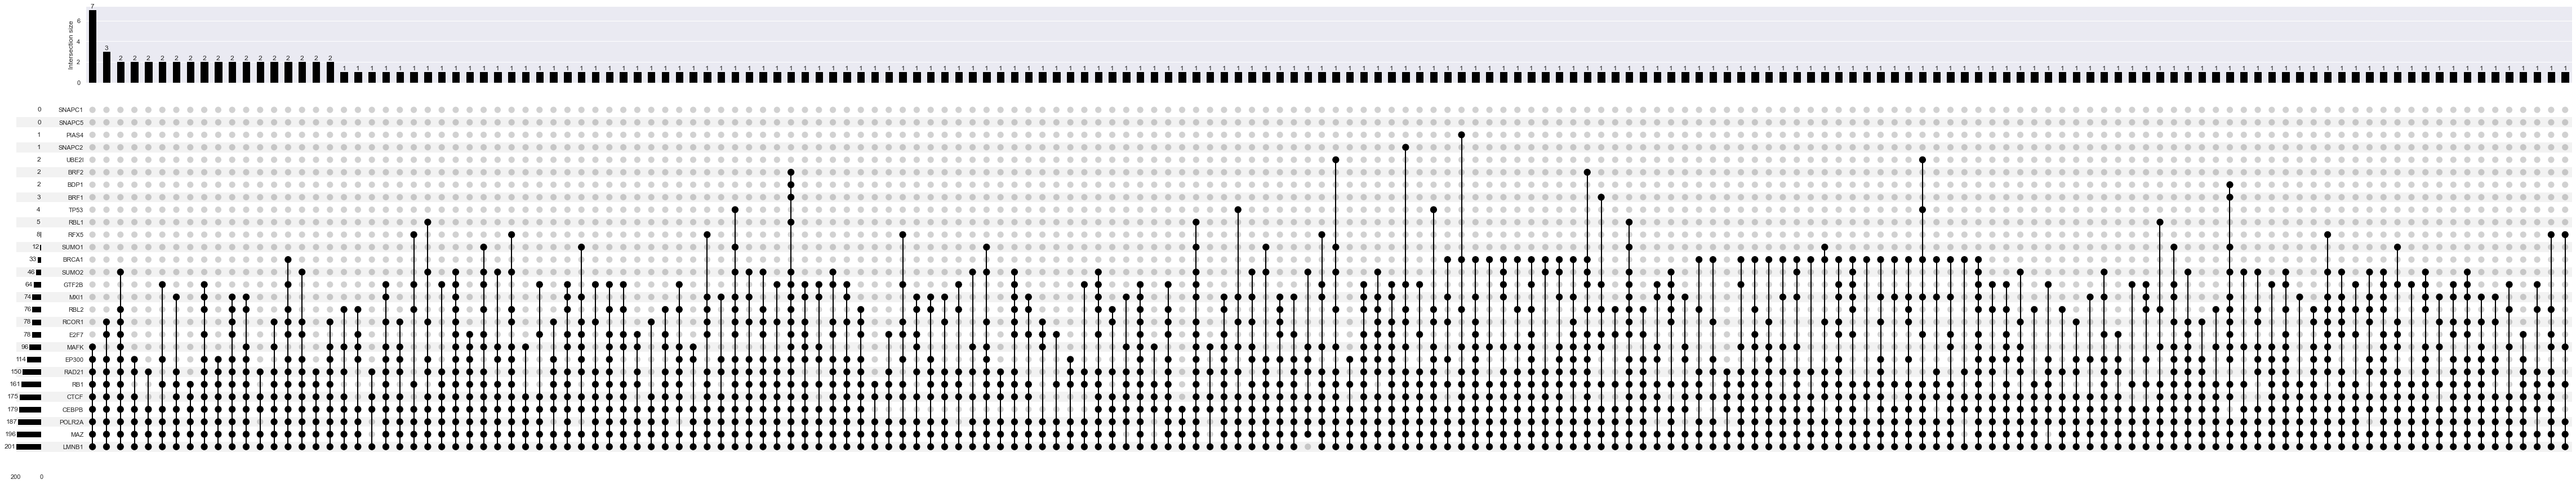

In [14]:
# Overlap of adhesome targets of TFs
dict_comp = {
    idx: target_df.loc[idx, 'target_adhesome_gene'] for idx in target_df.index
}
intersections = from_contents(dict_comp)

sns.set(font_scale=1)
fig = plt.figure()
upset = UpSet(intersections, subset_size='count', show_counts = True, 
              sort_by="cardinality", min_subset_size = 1).plot()
plt.show()

## Active adhesome genes are more co-targeted than random active targets

In [15]:
# Select random active genes (same number as adhesome genes)
np.random.seed(13)
active_random_genes = np.random.choice(
    list(set(active_genes)-set(active_adhesome_genes)),
    size=len(active_adhesome_genes),
    replace=False
)

In [16]:
# Add random genes to target_df
tftarget_df_lungfibro['active random target'] = tftarget_df_lungfibro['target_gene'].isin(active_random_genes)
df3 = tftarget_df_lungfibro[tftarget_df_lungfibro['active random target']]
df3 = df3.groupby('tf').agg({'target_gene': sorted})
df3.loc[:, 'n_target_random_gene'] = df3['target_gene'].apply(lambda ls: len(ls))
df3.columns = ['target_random_gene', 'n_target_random_gene']
target_df = pd.concat([target_df, df3], axis=1)

target_df['target_random_gene'] = target_df['target_random_gene'].fillna(
    pd.Series([[]] * len(target_df['target_random_gene']), index=target_df.index)
)
target_df['n_target_random_gene'] = target_df['n_target_random_gene'].fillna(0)

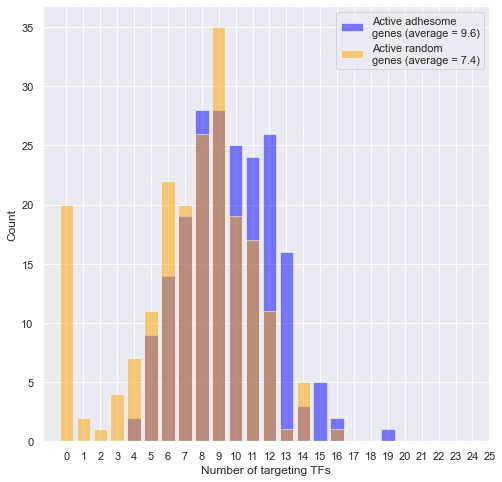

WRS p-value for number of targeting TFs between active adhesome loci and active random loci = 1.2637839071789824e-09


In [17]:
# Number of TFs targeting each adhesome gene (add also genes not targeted by any TFs)
n_adhesome_df = tftarget_df_lungfibro[tftarget_df_lungfibro['active adhesome target']]
n_adhesome_df = n_adhesome_df.groupby('target_gene')['tf'].count()
n_adhesome_df = n_adhesome_df.to_frame('n_tf_targeting')
for g in active_adhesome_genes:
    if (g not in n_adhesome_df.index):
        row_df = pd.DataFrame({'n_tf_targeting':0}, index=[g])
        n_adhesome_df = pd.concat([n_adhesome_df, row_df], axis=0)

# Number of TFs targeting each random gene (add also genes not targeted by any TFs)
n_random_df = tftarget_df_lungfibro[tftarget_df_lungfibro['active random target']]
n_random_df = n_random_df.groupby('target_gene')['tf'].count()
n_random_df = n_random_df.to_frame('n_tf_targeting')
for g in active_random_genes:
    if (g not in n_random_df.index):
        row_df = pd.DataFrame({'n_tf_targeting':0}, index=[g])
        n_random_df = pd.concat([n_random_df, row_df], axis=0)

# Compare
plt.figure(figsize=(8,8))
x1, height1 = np.unique(n_adhesome_df['n_tf_targeting'].values, return_counts=True)
plt.bar(
    x=x1,
    height=height1,
    color='blue',
    alpha=0.5,
    label=f"Active adhesome \ngenes (average = {np.round(np.mean(n_adhesome_df['n_tf_targeting'].values),1)})"
)
x2, height2 = np.unique(n_random_df['n_tf_targeting'].values, return_counts=True)
plt.bar(
    x=x2,
    height=height2,
    color='orange',
    alpha=0.5,
    label=f"Active random \ngenes (average = {np.round(np.mean(n_random_df['n_tf_targeting'].values),1)})"
)

max_x = max([max(x1), max(x2)])
plt.xticks(np.arange(0, max_x+7, 1))

plt.xlabel('Number of targeting TFs')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

stat, pval = ss.ranksums(
    x=n_adhesome_df['n_tf_targeting'].values,
    y=n_random_df['n_tf_targeting'].values,
    alternative='two-sided'
)
print(f"WRS p-value for number of targeting TFs between active adhesome loci and active random loci = {pval}")

In [18]:
# Make the analysis more robust by reporting the -log(WRS p-val) across multiple repetitions
n_rep = 1000
np.random.seed(13)

pval_list = []
for _ in tqdm(range(n_rep)):
    
    # Select random active genes (same number as adhesome genes)
    active_random_genes = np.random.choice(
        list(set(active_genes)-set(active_adhesome_genes)),
        size=len(active_adhesome_genes),
        replace=False
    )
    
    # Add random genes to tftarget_df_lungfibro
    tftarget_df_lungfibro['active random target'] = tftarget_df_lungfibro['target_gene'].isin(active_random_genes)
    
    # Number of TFs targeting each random gene (add also genes not targeted by any TFs)
    n_random_df = tftarget_df_lungfibro[tftarget_df_lungfibro['active random target']]
    n_random_df = n_random_df.groupby('target_gene')['tf'].count()
    n_random_df = n_random_df.to_frame('n_tf_targeting')
    for g in active_random_genes:
        if (g not in n_random_df.index):
            row_df = pd.DataFrame({'n_tf_targeting':0}, index=[g])
            n_random_df = pd.concat([n_random_df, row_df], axis=0)
    
    # WRS test
    stat, pval = ss.ranksums(
        x=n_adhesome_df['n_tf_targeting'].values,
        y=n_random_df['n_tf_targeting'].values,
        alternative='two-sided'
    )
    pval_list.append(pval)

neglopval_list = np.array([-np.log(p) for p in pval_list])

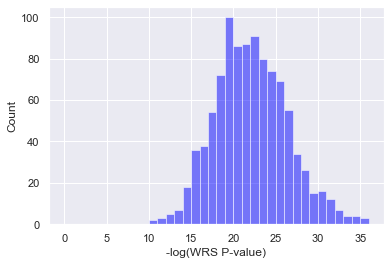

In [19]:
# Plot results
plt.figure()
plt.hist(
    x=neglopval_list,
    bins=np.arange(0, max(neglopval_list), 1),
    color='blue',
    alpha=0.5
)
plt.xlabel('-log(WRS P-value)')
plt.ylabel('Count')
plt.show()

# Proximity in Hi-C of TF targets

For each TF, retrieve the Hi-C contact values between its adhesome targets. Combine this into one vector.

Do the same with a random sample of active (non-adhesome) genes targeted by the same TFs. For each TF, find n active genes that it targets, where n is the number of active adhesome genes it targets. Get the list of corresponding Hi-C contacts.

Compare both distributions.

## Active adhesome targets

In [20]:
# Construct a dictionary mapping each TF to the Hi-C contact values between its adhesome targets
adhesome_hic_per_tf_dict = defaultdict(list)

for tf in tqdm(target_df.index):
    
    # Identify target loci
    target_adhesome_genes = target_df.loc[tf, 'target_adhesome_gene']
    target_adhesome_loci = [gene2locus[g] for g in target_adhesome_genes]
    target_adhesome_loci = sorted(itertools.chain.from_iterable(target_adhesome_loci))
    target_adhesome_loci = list(set(target_adhesome_loci)-set(blacklist_list))
    chromosomes = np.unique([int(loc.split('_')[1]) for loc in target_adhesome_loci])
    target_adhesome_loci_per_chrom_dict = defaultdict(list)
    for loc in target_adhesome_loci:
        target_adhesome_loci_per_chrom_dict[int(loc.split('_')[1])].append(loc)
    
    # Load HiC data for this chromosome pair and retrieve Hi-C contacts between the relevant loci
    for chr1, chr2 in itertools.combinations(chromosomes, 2):
        processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
        with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
            hic_chpair_df = pickle.load(f) 
        
        loci_pairs = list(itertools.product(
            target_adhesome_loci_per_chrom_dict[chr1], target_adhesome_loci_per_chrom_dict[chr2]
        ))
        
        for locus1_id, locus2_id in loci_pairs:
            locus1 = int(locus1_id.split('_')[3])
            locus2 = int(locus2_id.split('_')[3])
            adhesome_hic_per_tf_dict[tf].append(hic_chpair_df.loc[locus1,locus2])

In [21]:
# Combine all per-TF Hi-C contact values
adhesome_TF_target_hic_values = list(itertools.chain.from_iterable(adhesome_hic_per_tf_dict.values()))

## Random active targets

In [22]:
# Construct a dictionary mapping each TF to the Hi-C contact values between its random targets
np.random.seed(13)

random_hic_per_tf_dict = defaultdict(list)
for tf in tqdm(target_df.index):
    
    # Select random active genes which are not targeted by the TF but sit on the same chromosome
    all_targets = target_df.loc[tf, 'target_gene']
    adhesome_targets = target_df.loc[tf, 'target_adhesome_gene']
    adhesome_targets_loci = sorted(itertools.chain.from_iterable([gene2locus[g] for g in adhesome_targets]))
    adhesome_targets_chroms = np.array([int(gene2chrom[g][3:]) for g in adhesome_targets])
    n_adhesome_targets_per_chrom = {
       chrom: np.sum(adhesome_targets_chroms==chrom) for chrom in chrom_list
    }
    target_random_genes = [
        np.random.choice(
            list(set(active_genes_per_chrom[chrom])-set(all_targets)),
            size=n_adhesome_targets_per_chrom[chrom],
            replace=False
        ) for chrom in chrom_list
    ]
    target_random_genes = list(itertools.chain.from_iterable(target_random_genes))
    
    # Identify target loci
    target_random_loci = [
        gene2locus[g] for g in target_random_genes
    ]
    target_random_loci = sorted(itertools.chain.from_iterable(target_random_loci))
    target_random_loci = list(set(target_random_loci)-set(blacklist_list))
    chromosomes = np.unique([int(loc.split('_')[1]) for loc in target_random_loci])
    target_random_loci_per_chrom_dict = defaultdict(list)
    for loc in target_random_loci:
        target_random_loci_per_chrom_dict[int(loc.split('_')[1])].append(loc)
    
    # Load HiC data for this chromosome pair and retrieve Hi-C contacts between the relevant loci
    for chr1, chr2 in itertools.combinations(chromosomes, 2):
        processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
        with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
            hic_chpair_df = pickle.load(f) 
        
        loci_pairs = list(itertools.product(
            target_random_loci_per_chrom_dict[chr1], target_random_loci_per_chrom_dict[chr2]
        ))
        
        for locus1_id, locus2_id in loci_pairs:
            locus1 = int(locus1_id.split('_')[3])
            locus2 = int(locus2_id.split('_')[3])
            random_hic_per_tf_dict[tf].append(hic_chpair_df.loc[locus1,locus2])

In [23]:
# Combine all per-TF Hi-C contact values
random_TF_target_hic_values = list(itertools.chain.from_iterable(random_hic_per_tf_dict.values()))

## Compare active adhesome genes and active random genes

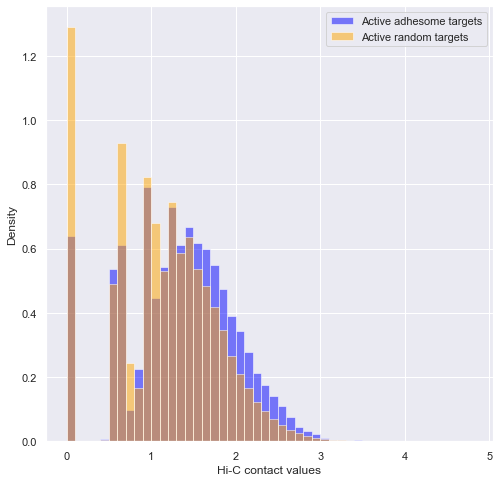

WRS stat and p-value for distributions of Hi-C contact among active       adhesome targets and active random targets of adhesome TFs = 94.73811489412377, 0.0


In [24]:
# Compare
max_val = max([max(adhesome_TF_target_hic_values), max(random_TF_target_hic_values)])
plt.figure(figsize=(8,8))
plt.hist(
    x=adhesome_TF_target_hic_values,
    bins=np.arange(0, max_val, 0.1),
    density=True,
    color='blue',
    alpha=0.5,
    label='Active adhesome targets'
)
plt.hist(
    x=random_TF_target_hic_values,
    bins=np.arange(0, max_val, 0.1),
    density=True,
    color='orange',
    alpha=0.5,
    label='Active random targets'
)
plt.xlabel('Hi-C contact values')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

stat, pval = ss.ranksums(
    x=adhesome_TF_target_hic_values,
    y=random_TF_target_hic_values,
    alternative='two-sided'
)
print(f"WRS stat and p-value for distributions of Hi-C contact among active \
      adhesome targets and active random targets of adhesome TFs = {stat}, {pval}")

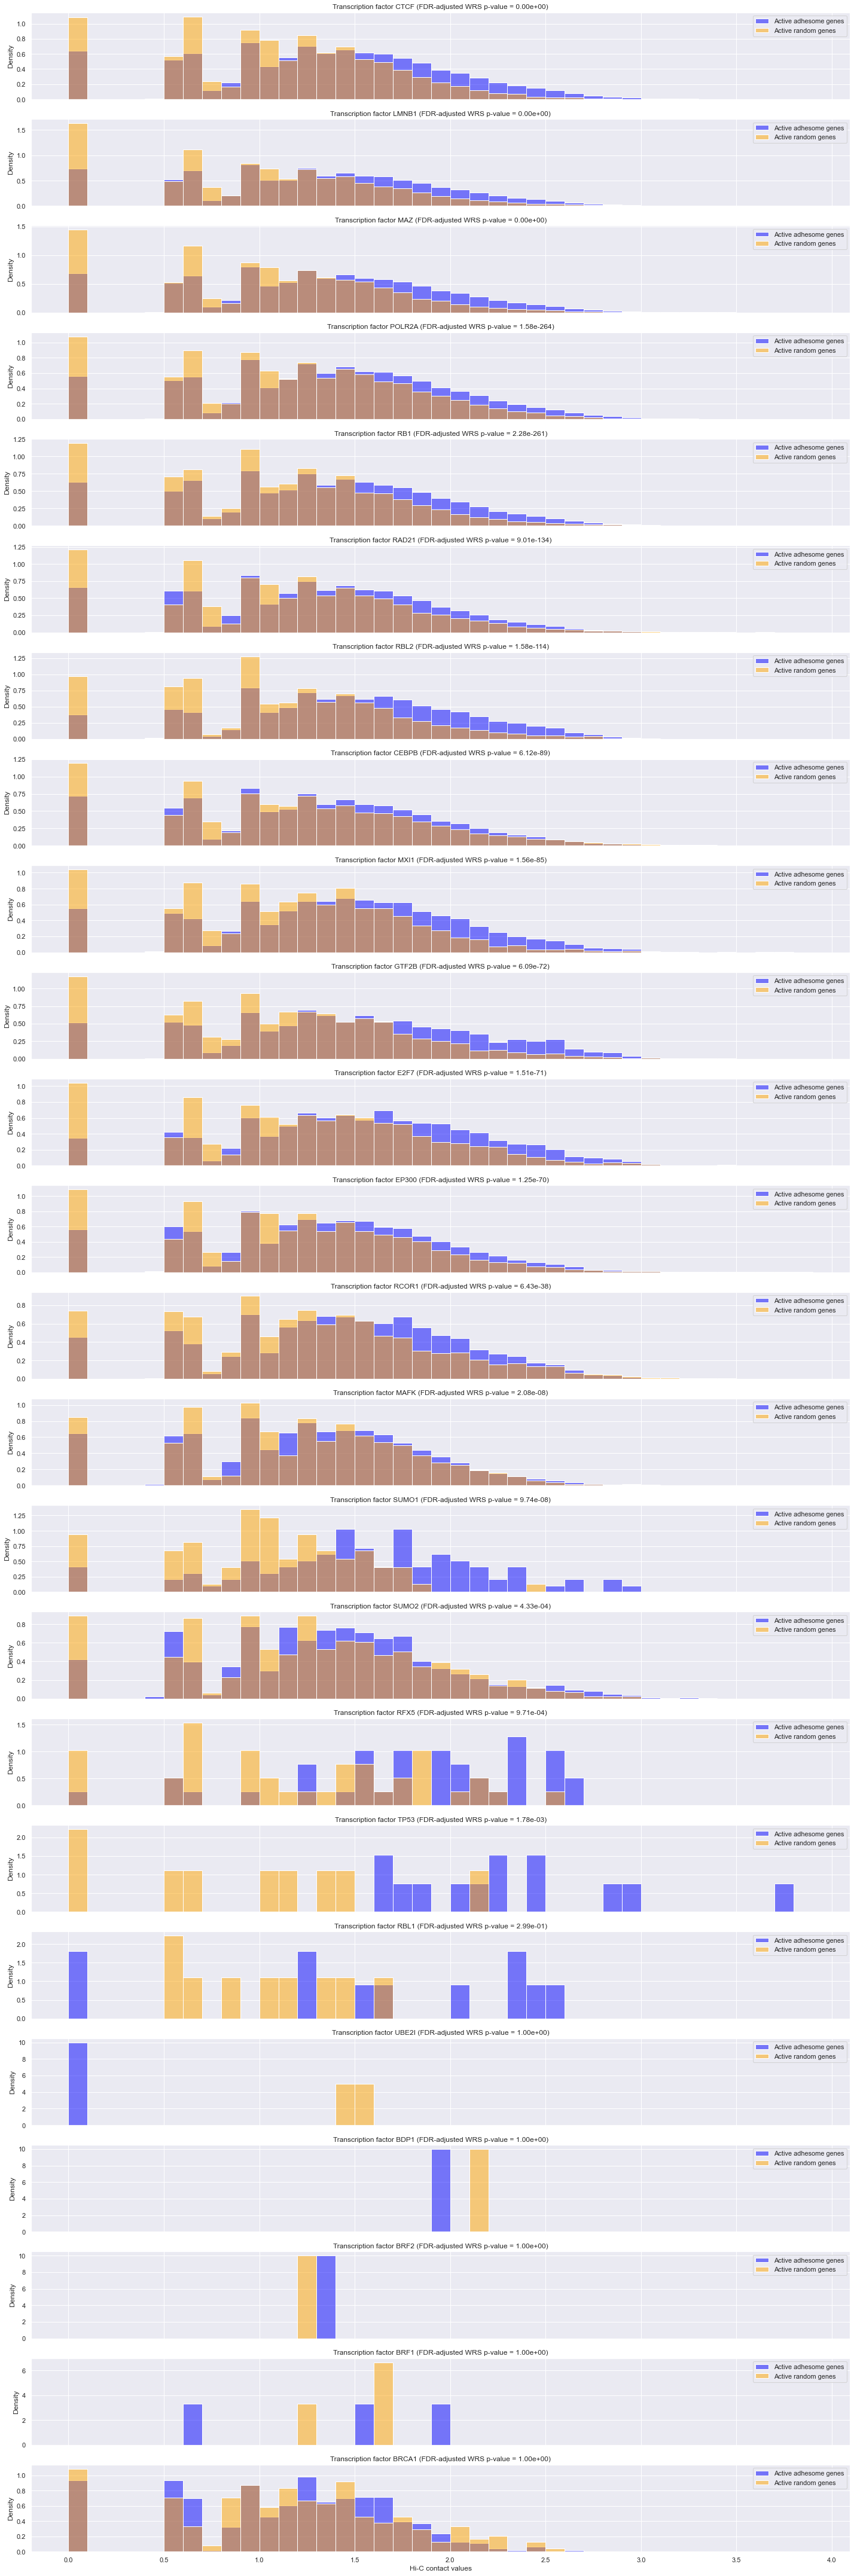

In [26]:
# Stratify results by TF
fig, axes = plt.subplots(
    nrows=len(adhesome_hic_per_tf_dict.keys()), 
    ncols=1, 
    figsize=(20, 60), 
    sharex=True, 
    sharey=False
)

# Create list of TFs ordered by their significance (to have plots in increasing order of significance)
ordered_tf_list = []
for tf in adhesome_hic_per_tf_dict.keys():
    df_adhesome = pd.DataFrame({'hic': adhesome_hic_per_tf_dict[tf], 'Targets': 'Active adhesome targets'})
    df_random = pd.DataFrame({'hic': random_hic_per_tf_dict[tf], 'Targets': 'Active random targets'})
    df_combined = pd.concat([df_adhesome, df_random], axis=0).reset_index(drop=True)
    
    stat, pval = ss.ranksums(
        x=df_adhesome['hic'].values,
        y=df_random['hic'].values,
        alternative='two-sided'
    )
    ordered_tf_list.append((tf, pval))
ordered_tf_list = sorted(ordered_tf_list, key=lambda x: x[1])
ordered_pval_list = [x[1] for x in ordered_tf_list]
ordered_tf_list = [x[0] for x in ordered_tf_list]

# BH FDR correction of TF p-values
ordered_adjusted_pval_list = multipletests(
    ordered_pval_list, 
    alpha=0.05,
    method='fdr_by',
    is_sorted=True
)[1]

# Plot the histograms on each subplot
for i, tf in enumerate(ordered_tf_list):
    df_adhesome = pd.DataFrame({'hic': adhesome_hic_per_tf_dict[tf], 'Targets': 'Active adhesome targets'})
    df_random = pd.DataFrame({'hic': random_hic_per_tf_dict[tf], 'Targets': 'Active random targets'})
    df_combined = pd.concat([df_adhesome, df_random], axis=0).reset_index(drop=True)
    pval = ordered_adjusted_pval_list[i]
    
    sns.histplot(
        data=df_adhesome, 
        x='hic',
        stat='density',
        bins=np.arange(0, 4, 0.1),
        color='blue',
        alpha=0.5,
        label='Active adhesome genes',
        ax=axes[i]
    )
    sns.histplot(
        data=df_random, 
        x='hic',
        stat='density',
        bins=np.arange(0, 4, 0.1),
        color='orange',
        alpha=0.5,
        label='Active random genes',
        ax=axes[i]
    )
    axes[i].legend(loc='upper right')
    
    if np.isnan(pval):
        pval = 1
    axes[i].set_title(f"Transcription factor {tf} (FDR-adjusted WRS p-value = {'{:.2e}'.format(pval)})")

# Set common x-axis label
plt.xlabel('Hi-C contact values')

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()

In [27]:
# Make the analysis more robust by reporting the -log(WRS p-val) across multiple repetitions
n_rep = 1000
np.random.seed(13)

pval_list = []
stat_list = []
for _ in tqdm(range(n_rep)):
    
    #################################
    # Get Hi-C contact among random genes
    #################################
    
    random_hic_per_tf_dict = defaultdict(list)
    for tf in target_df.index:

        # Select random active genes which are not targeted by the TF but sit on the same chromosome
        all_targets = target_df.loc[tf, 'target_gene']
        adhesome_targets = target_df.loc[tf, 'target_adhesome_gene']
        adhesome_targets_chroms = np.array([int(gene2chrom[g][3:]) for g in adhesome_targets])
        n_adhesome_targets_per_chrom = {
           chrom: np.sum(adhesome_targets_chroms==chrom) for chrom in chrom_list
        }
        target_random_genes = [
            np.random.choice(
                list(set(active_genes_per_chrom[chrom])-set(all_targets)),
                size=n_adhesome_targets_per_chrom[chrom],
                replace=False
            ) for chrom in chrom_list
        ]
        target_random_genes = list(itertools.chain.from_iterable(target_random_genes))
        
        # Identify target loci
        target_random_loci = [gene2locus[g] for g in target_random_genes]
        target_random_loci = sorted(itertools.chain.from_iterable(target_random_loci))
        target_random_loci = list(set(target_random_loci)-set(blacklist_list))
        chromosomes = np.unique([int(loc.split('_')[1]) for loc in target_random_loci])
        target_random_loci_per_chrom_dict = defaultdict(list)
        for loc in target_random_loci:
            target_random_loci_per_chrom_dict[int(loc.split('_')[1])].append(loc)

        # Load HiC data for this chromosome pair and retrieve Hi-C contacts between the relevant loci
        for chr1, chr2 in itertools.combinations(chromosomes, 2):
            processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
            with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
                hic_chpair_df = pickle.load(f) 

            loci_pairs = list(itertools.product(
                target_random_loci_per_chrom_dict[chr1], target_random_loci_per_chrom_dict[chr2]
            ))

            for locus1_id, locus2_id in loci_pairs:
                locus1 = int(locus1_id.split('_')[3])
                locus2 = int(locus2_id.split('_')[3])
                random_hic_per_tf_dict[tf].append(hic_chpair_df.loc[locus1,locus2])

    # Combine all per-TF Hi-C contact values
    random_TF_target_hic_values = list(itertools.chain.from_iterable(random_hic_per_tf_dict.values()))
    
    #################################
    # Compute WRS p-value
    #################################
    stat, pval = ss.ranksums(
        x=adhesome_TF_target_hic_values,
        y=random_TF_target_hic_values,
        alternative='two-sided'
    )
    pval_list.append(pval)
    stat_list.append(stat)

# neglopval_list = np.array([-np.log(p) if p>0 else -np.log(np.unique(pval_list)[1]) for p in pval_list])

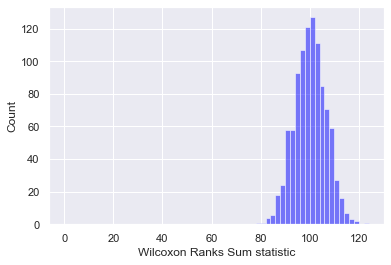

In [29]:
# Plot results
# plt.figure()
# plt.hist(
#     x=neglopval_list,
#     bins=np.arange(0, max(neglopval_list)+10, 10),
#     color='blue',
#     alpha=0.5
# )
# plt.xlabel('-log(WRS P-value)')
# plt.ylabel('Count')
# plt.show()

plt.figure()
plt.hist(
    x=stat_list,
    bins=np.arange(0, max(stat_list)+1, 2),
    color='blue',
    alpha=0.5
)
plt.xlabel('Wilcoxon Ranks Sum statistic')
plt.ylabel('Count')
plt.show()

# Recruitment of TFs by their targets

- Load and process TF ChIP-seq
- Count recruitment of TF for each target gene present in hTFtarget, add it as an extra column
- Identify the genes that recruit the most of their TFs, and use these genes only for the Hi-C analysis --> this should strengthen the signal

## Lung fibroblast TFs

In [41]:
# Select only TF-target pairs in lung fibroblasts
all_lung_cell_lines = tftarget_df[tftarget_df['tissue']=='lung']['cell_line'].unique()
lung_fibroblasts = ['IMR90', 'WI38', 'AG04450', 'HPF', 'NHLF']
tftarget_df_lungfibro = tftarget_df[tftarget_df['cell_line'].isin(lung_fibroblasts)]
tftarget_df_lungfibro.head()

,tf,target_gene,target_id,target_synonym,dataset_id,cell_line,cell_type,fibroblast,tissue,disease,condition,project,samples,control,source
35350,LMNB1,AGBL5-AS1,ENSG00000231636,[],1927,IMR90,lung fibroblast cell,True,lung,normal,fibroblast,"['GSE36616', ' GSE36641']",['GSM897558'],NaN,NCBI
35351,LMNB1,AGBL5,ENSG00000084693,"['CCP5', 'RP75']",1927,IMR90,lung fibroblast cell,True,lung,normal,fibroblast,"['GSE36616', ' GSE36641']",['GSM897558'],NaN,NCBI
35352,LMNB1,RP11-204L24.2,ENSG00000265451,[],1927,IMR90,lung fibroblast cell,True,lung,normal,fibroblast,"['GSE36616', ' GSE36641']",['GSM897558'],NaN,NCBI
35353,LMNB1,CLASP1,ENSG00000074054,['MAST1'],1927,IMR90,lung fibroblast cell,True,lung,normal,fibroblast,"['GSE36616', ' GSE36641']",['GSM897558'],NaN,NCBI
35354,LMNB1,RNU4ATAC,ENSG00000264229,"['MOPD1', 'RFMN', 'RNU4ATAC1', 'TALS', 'U4ATAC']",1927,IMR90,lung fibroblast cell,True,lung,normal,fibroblast,"['GSE36616', ' GSE36641']",['GSM897558'],NaN,NCBI


## Download ChIP-seq data

In [42]:
# Create dictionary mapping projects to samples
project2samples_dict = defaultdict(list)
for idx in tqdm(tftarget_df_lungfibro.index):
    # Project
    project = tftarget_df_lungfibro.loc[idx, 'project']
    project = project.split(', ')[0]
    project = project.strip("['']").strip()
    
    # Samples
    samples = tftarget_df_lungfibro.loc[idx, 'samples']
    samples = samples.split(', ')
    samples = [x.strip("['']").strip() for x in samples]
    samples = np.unique(samples)

    # Add to dictionary
    for sample in samples:
        if (sample not in project2samples_dict[project]):
            project2samples_dict[project].append(sample)

In [43]:
# Some basic stats about the projects and samples we will download
n_projects = len(np.unique(list(project2samples_dict.keys())))
n_samples = len(np.unique(list(itertools.chain.from_iterable(list(project2samples_dict.values())))))
print(f"Total number of projects = {n_projects}")
print(f"Total number of samples = {n_samples}")

Total number of projects = 22
Total number of samples = 82


In [44]:
# Create dictionary mapping samples to TF
tftarget_df_lungfibro_sub = tftarget_df_lungfibro[['tf', 'samples']]
tftarget_df_lungfibro_sub['samples'] = tftarget_df_lungfibro_sub['samples'].str.split(',')
tftarget_df_lungfibro_sub['samples'] = tftarget_df_lungfibro_sub['samples'].apply(
    lambda ls: [x.strip("[', ']") for x in ls]
)
tftarget_df_lungfibro_sub = tftarget_df_lungfibro_sub.groupby('tf').agg({'samples': sum})
tftarget_df_lungfibro_sub['samples'] = tftarget_df_lungfibro_sub['samples'].apply(
    lambda ls: np.unique(ls)
)

samples2tf_dict = defaultdict(list)
for tf in tqdm(tftarget_df_lungfibro_sub.index):
    for sample in tftarget_df_lungfibro_sub.loc[tf, 'samples']:
        samples2tf_dict[sample] = tf

In [271]:
# Download samples for each project
sample2genomebuild = {}

for project in tqdm(project2samples_dict.keys()):
    gse = GEOparse.get_GEO(
        geo=project, 
        destdir="/home/louiscam/projects/gpcr/code/analysis4_adhesome_tfs/GEOparse_out/"
    )
    samples = project2samples_dict[project]
    
    for gsm_name, gsm in gse.gsms.items():
        
        if (gsm_name in project2samples_dict[project]):
        
            supplementary_files = gsm.metadata['supplementary_file_1']
            if (supplementary_files[0]=='NONE'):
                continue

            for file_url in supplementary_files:
                filename = file_url.split("/")[-1]
                if (filename not in os.listdir(dir_htftarget_peaks)):
                    subprocess.run(
                        ['wget', file_url], 
                        cwd=dir_htftarget_peaks
                    )
                if filename[-3:]=='.gz':
                    subprocess.run(
                        ['gunzip', filename], 
                        cwd=dir_htftarget_peaks
                    )
            
            # Record which genome build was used for this sample
            x = " ".join(list(itertools.chain.from_iterable(list(gsm.metadata.values()))))
            for genomebuild in ['hg19', 'hg18', 'hg38']:
                if (genomebuild in x): 
                    sample2genomebuild[gsm_name] = genomebuild

20-Jul-2023 09:17:46 DEBUG utils - Directory /home/louiscam/projects/gpcr/code/analysis4_adhesome_tfs/GEOparse_out/ already exists. Skipping.
20-Jul-2023 09:17:46 INFO GEOparse - File already exist: using local version.
20-Jul-2023 09:17:46 INFO GEOparse - Parsing /home/louiscam/projects/gpcr/code/analysis4_adhesome_tfs/GEOparse_out/GSE36616_family.soft.gz: 
20-Jul-2023 09:17:46 DEBUG GEOparse - DATABASE: GeoMiame
20-Jul-2023 09:17:46 DEBUG GEOparse - SERIES: GSE36616
20-Jul-2023 09:17:46 DEBUG GEOparse - PLATFORM: GPL10999
20-Jul-2023 09:17:46 DEBUG GEOparse - PLATFORM: GPL11154
20-Jul-2023 09:17:46 DEBUG GEOparse - SAMPLE: GSM897555
20-Jul-2023 09:17:46 DEBUG GEOparse - SAMPLE: GSM897556
20-Jul-2023 09:17:46 DEBUG GEOparse - SAMPLE: GSM897557
20-Jul-2023 09:17:46 DEBUG GEOparse - SAMPLE: GSM897558
20-Jul-2023 09:17:46 DEBUG GEOparse - SAMPLE: GSM897559
20-Jul-2023 09:17:46 DEBUG GEOparse - SAMPLE: GSM897560
20-Jul-2023 09:17:46 DEBUG GEOparse - SAMPLE: GSM897561
20-Jul-2023 09:17:46 

20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935347
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935348
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935349
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935350
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935351
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935352
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935353
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935354
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935355
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935356
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935357
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935358
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935359
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935360
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935361
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935362
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GSM935363
20-Jul-2023 09:17:48 DEBUG GEOparse - SAMPLE: GS

20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935494
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935495
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935496
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935497
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935498
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935499
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935500
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935501
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935502
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935503
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935504
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935505
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935506
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935507
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935508
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935509
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935510
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GS

20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935641
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935642
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935643
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935644
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935645
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935646
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935647
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935648
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935649
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935650
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935651
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935652
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM935653
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM1003602
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM1003603
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM1003604
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE: GSM1003605
20-Jul-2023 09:17:49 DEBUG GEOparse - SAMPLE

20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749734
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749735
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749736
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749737
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749738
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749739
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749740
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749741
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749742
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749743
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749744
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749745
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749746
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749747
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749748
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749749
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GSM749750
20-Jul-2023 09:17:52 DEBUG GEOparse - SAMPLE: GS

20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035425
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035426
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035427
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035428
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035429
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035430
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035431
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035432
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035433
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035434
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035435
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035436
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035437
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035438
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035439
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035440
20-Jul-2023 09:17:54 DEBUG GEOparse - SAMPLE: GSM1035441
20-Jul-2023 09:17:54 DEBUG GEOp

20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646319
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646320
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646321
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646322
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646323
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646324
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646325
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646326
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646327
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646328
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646329
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646330
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646331
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646332
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646333
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646334
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646335
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GS

20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646466
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646467
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646468
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646469
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646470
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646471
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646472
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646473
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646474
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646475
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646476
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646477
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646478
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646479
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646480
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646481
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GSM646482
20-Jul-2023 09:17:58 DEBUG GEOparse - SAMPLE: GS

20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733654
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733655
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733656
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733657
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733658
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733659
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733660
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733661
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733662
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733663
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733664
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733665
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733666
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733667
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733668
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733669
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM733670
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GS

20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003456
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003457
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003458
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003459
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003460
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003461
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003462
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003463
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003464
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003465
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003466
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003467
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003468
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003469
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003470
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003471
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1003472
20-Jul-2023 09:18:00 DEBUG GEOp

20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007984
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007985
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007986
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007987
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007988
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007989
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007990
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007991
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007992
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007993
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007994
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007995
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007996
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007997
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007998
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1007999
20-Jul-2023 09:18:00 DEBUG GEOparse - SAMPLE: GSM1008000
20-Jul-2023 09:18:00 DEBUG util

20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665825
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665826
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665827
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665828
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665829
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665830
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665831
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665832
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665833
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665834
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665835
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665836
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665837
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665838
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665839
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM665840
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GSM701487
20-Jul-2023 09:19:34 DEBUG GEOparse - SAMPLE: GS

20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM774242
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM774243
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM774244
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817158
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817159
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817160
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817161
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817162
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817163
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817164
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817165
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817166
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817167
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817168
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817169
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817170
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GSM817171
20-Jul-2023 09:20:24 DEBUG GEOparse - SAMPLE: GS

20-Jul-2023 09:20:49 DEBUG GEOparse - SAMPLE: GSM943584
20-Jul-2023 09:20:51 DEBUG GEOparse - SAMPLE: GSM943585
20-Jul-2023 09:20:53 DEBUG GEOparse - SAMPLE: GSM943586
20-Jul-2023 09:20:54 DEBUG GEOparse - SAMPLE: GSM943587
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1024605
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1024606
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1024607
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1024608
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1024609
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1024610
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1027287
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1027288
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1027289
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1027290
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1027291
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1027292
20-Jul-2023 09:20:56 DEBUG GEOparse - SAMPLE: GSM1027293
20-Jul-2023 09:20:56 DEBUG GEOparse

20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059521
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059522
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059523
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059524
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059525
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059526
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059527
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059528
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059529
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059530
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059531
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059532
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059533
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059534
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059535
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1059536
20-Jul-2023 09:20:57 DEBUG GEOparse - SAMPLE: GSM1060237
20-Jul-2023 09:20:57 DEBUG GEOp

20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220570
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220571
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220572
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220573
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220574
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220575
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220576
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220577
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220578
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220579
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220580
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220581
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220582
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220583
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220584
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220585
20-Jul-2023 09:21:04 DEBUG GEOparse - SAMPLE: GSM1220586
20-Jul-2023 09:21:04 DEBUG GEOp

## Process ChIP-seq data

In [45]:
# Columns of a BED file, for reference
bed_columns = [
    'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand'
]

In [46]:
# List of samples to process
samples_list = [
    s for s in sorted(os.listdir(dir_htftarget_peaks)) 
    if s.split('.')[-1] in ['narrowPeak', 'broadPeak', 'bed', 'xls', 'bedGraph', 'bedgraph']
]

In [47]:
# We need to break down the processing into several batches due to RAM limitations
thresholds_list = [
    (0, 1e8),
    (1e8, 1e9),
    (1e9, 1.2e9),
    (1.2e9, 1.5e9),
    (1.5e9, 1.6e9),
    (1.6e9, 1.8e9),
    (1.8e9, 2.4e9)
]

In [275]:
# We process the data in different batches depending on its size
for i, threshs in enumerate(thresholds_list):
    thresh1, thresh2 = threshs
    
    # Selection of samples within a given size range
    subsamples_list = [
        (f, os.stat(os.path.join(dir_htftarget_peaks, f)).st_size) for f in samples_list
        if ((os.stat(os.path.join(dir_htftarget_peaks, f)).st_size>=thresh1) &
        (os.stat(os.path.join(dir_htftarget_peaks, f)).st_size<thresh2))
    ]

    # Load and process samples
    sample2data = {}
    for filename, size in tqdm(subsamples_list):
        sample = filename.split('_')[0]
        extension = filename.split('.')[-1]
        tf = samples2tf_dict[sample]

        if (sample[:3]=='GSM'):
            print(f'Sample {sample} for {tf} (size={size/1e6}Mb)')

            print(f'\tRead peaks data')
            if (extension=='narrowPeak'):
                df = pd.read_csv(dir_htftarget_peaks+filename, sep='\t', header=None, index_col=None)
                df.columns = [
                    'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 
                    'signalValue', 'pValue', 'qValue', 'peak'
                ]
            elif (extension=='broadPeak'):
                df = pd.read_csv(dir_htftarget_peaks+filename, sep='\t', header=None, index_col=None)
                df.columns = [
                    'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 
                    'signalValue', 'pValue', 'qValue'
                ]
            elif (extension=='bed'):
                df = pd.read_csv(dir_htftarget_peaks+filename, sep='\t', header=None, index_col=None)
                df.columns = bed_columns[:df.shape[1]]
            elif (extension in ['bedgraph', 'bedGraph']):
                df = pd.read_csv(dir_htftarget_peaks+filename, sep='\t', header=None, index_col=None, skiprows=1)
                df.columns = [
                    'chrom', 'chromStart', 'chromEnd', 'dataValue'
                ]
            elif (extension=='xls'):
                df = pd.read_csv(dir_htftarget_peaks+filename, sep='\t', header=0, index_col=None)
                df.columns = [
                    'chrom', 'chromStart', 'chromEnd', 'length', 'summit', 'tags', '-10*log10(pvalue)', 
                    'fold_enrichment', 'FDR(%)'
                ]
    #         elif (extension=='bw'):
    #             radical = filename.split('.')[0]
    #             subprocess.run(
    #                 ['./bigWigToBedGraph', filename, radical+'.bedGraph'], 
    #                 cwd=dir_htftarget_peaks
    #             )
    #             df = pd.read_csv(
    #                 dir_htftarget_peaks+radical+'.bedGraph', sep='\t', header=None, index_col=None, skiprows=1
    #             )
    #             df.columns = [
    #                 'chrom', 'chromStart', 'chromEnd', 'dataValue'
    #             ]
    #         elif (extension=='wig'):
    #             radical = filename.split('.')[0]
    #             hg = sample2genomebuild[sample]
    #             chrom_sizes = f'http://hgdownload.soe.ucsc.edu/goldenPath/{hg}/bigZips/{hg}.chrom.sizes'
    #             subprocess.run(
    #                 [dir_htftarget_peaks+'wigToBigWig', '-clip', filename, chrom_sizes, radical+'.bw'], 
    #                 cwd=dir_htftarget_peaks
    #             )
    #             subprocess.run(
    #                 ['./bigWigToBedGraph', radical+'.bw', radical+'.bedGraph'], 
    #                 cwd=dir_htftarget_peaks
    #             )
    #             df = pd.read_csv(dir_htftarget_peaks+radical+'.bedGraph', sep='\t', header=None, index_col=None)
    #             df.columns = [
    #                 'chrom', 'chromStart', 'chromEnd', 'dataValue'
    #             ]
            else:
                continue

            # Create BED object from ChIP-seq dataframe
            df = df[['chrom', 'chromStart', 'chromEnd']]
            print('\tAdd name')
            df.loc[:, 'name'] = df.index
            print('\tCreate BED')
            df.columns = ['chrom', 'start', 'end', 'name']
            sample_bed = pybedtools.BedTool.from_dataframe(df)
            del df
            print('\tSort BED')
            sample_bed = sample_bed.sort()
            # Map ChIP-seq peaks to genome
            hg = sample2genomebuild[sample]
            print(f'\tMap to {hg} genome')
            gene_bed = df_loc_bed_dict[hg]
            out = pybedtools.bedtool.BedTool.map(
                gene_bed, 
                sample_bed, 
                c=[4], 
                o='count_distinct',
#                 f=0.1
            )
            del sample_bed
            out = out.to_dataframe()
            out.columns = ['chrom', 'start', 'end', 'name', tf]
            out = out[['name', tf]]
            out = out.set_index('name')
            # Normalize signal by gene length
            print(f'\tNormalize by gene length')
            div_series = df_loc_dict[hg][
                ['geneSymbol', 'geneLength']
            ].set_index('geneSymbol').loc[out.index]['geneLength']
            out=out.divide(
                div_series, 
                axis='rows', 
                level=None, 
                fill_value=None
            )
            out = np.log(1+1e6*out)
            print(f'\tStore in dictionary')
            sample2data[sample] = out

    # Save dict to pickle
    print(f'Save as pickle {i}')
    sample2data_vals = list(sample2data.values())
    mapped_peaks_df = pd.concat(sample2data_vals, axis=1, join='outer')
#     with open(saving_dir+f'mapped_peaks_df_{i}.pkl', 'wb') as f:
#         pickle.dump(mapped_peaks_df, f)

Sample GSM1003612 for RCOR1 (size=0.673014Mb)
	Read peaks data
	Add name
	Create BED
	Sort BED
	Map to hg19 genome
	Store in dictionary
Sample GSM1003613 for MAZ (size=1.163446Mb)
	Read peaks data
	Add name
	Create BED
	Sort BED
	Map to hg19 genome
	Store in dictionary
Sample GSM1003614 for MXI1 (size=0.941168Mb)
	Read peaks data
	Add name
	Create BED
	Sort BED
	Map to hg19 genome
	Store in dictionary
Sample GSM1003615 for RFX5 (size=0.107672Mb)
	Read peaks data
	Add name
	Create BED
	Sort BED
	Map to hg19 genome
	Store in dictionary
Sample GSM1003623 for CHD1 (size=0.339594Mb)
	Read peaks data
	Add name
	Create BED
	Sort BED
	Map to hg19 genome
	Store in dictionary
Sample GSM1022626 for CTCF (size=11.367646Mb)
	Read peaks data
	Add name
	Create BED
	Sort BED
	Map to hg19 genome
	Store in dictionary
Sample GSM1022634 for CTCF (size=9.110392Mb)
	Read peaks data
	Add name
	Create BED
	Sort BED
	Map to hg19 genome
	Store in dictionary
Sample GSM1022635 for CTCF (size=9.151127Mb)
	Read pea

## Recruitment by gene targets

In [48]:
# Read in the mapped peaks files and construct the gene x peak dataframe
mapped_peaks_df_list = []
for i, threshs in enumerate(thresholds_list):
    with open(saving_dir+f'mapped_peaks_df_{i}.pkl', 'rb') as f:
        mapped_peaks_df = pickle.load(f)
    mapped_peaks_df_list.append(mapped_peaks_df)

mapped_peaks_df = pd.concat(mapped_peaks_df_list, axis=1, join='outer')

In [49]:
# Process mapped peaks (drop NaNs, average columns for same mark, z-score)
mapped_peaks_df = mapped_peaks_df.dropna()
mapped_peaks_df = mapped_peaks_df.groupby(by=mapped_peaks_df.columns, axis=1).mean()
mapped_peaks_df = mapped_peaks_df.apply(zscore)
mapped_peaks_df = mapped_peaks_df.dropna(axis=1)
mapped_peaks_df.index.name = 'Active genes'
mapped_peaks_df.columns.name = 'Lung fibroblast TFs'

In [50]:
# Check the missing peaks
peaks_in_original_data = set(np.sort(tftarget_df_lungfibro['tf'].unique()))
peaks_in_processed_data = set(mapped_peaks_df.columns)
print(f"Missing peaks = {peaks_in_original_data-peaks_in_processed_data}")

Missing peaks = {'SPI1'}


## Analysis

In [116]:
# Identify adhesome genes present in the peaks dataframe
active_genes_sub = np.array([g for g in active_genes if (g in mapped_peaks_df.index)])
active_adhesome_genes_sub = np.array([g for g in active_adhesome_genes if (g in mapped_peaks_df.index)])
peaks_for_adhesome_dict = {
    col: mapped_peaks_df.loc[active_adhesome_genes_sub, col].values for col in mapped_peaks_df.columns
}
print(f"Active adhesome genes not present = {set(active_adhesome_genes)-set(active_adhesome_genes_sub)}")

Active adhesome genes not present = {'PLEC', 'ARHGAP32', 'PEAK1'}


<Figure size 432x288 with 0 Axes>

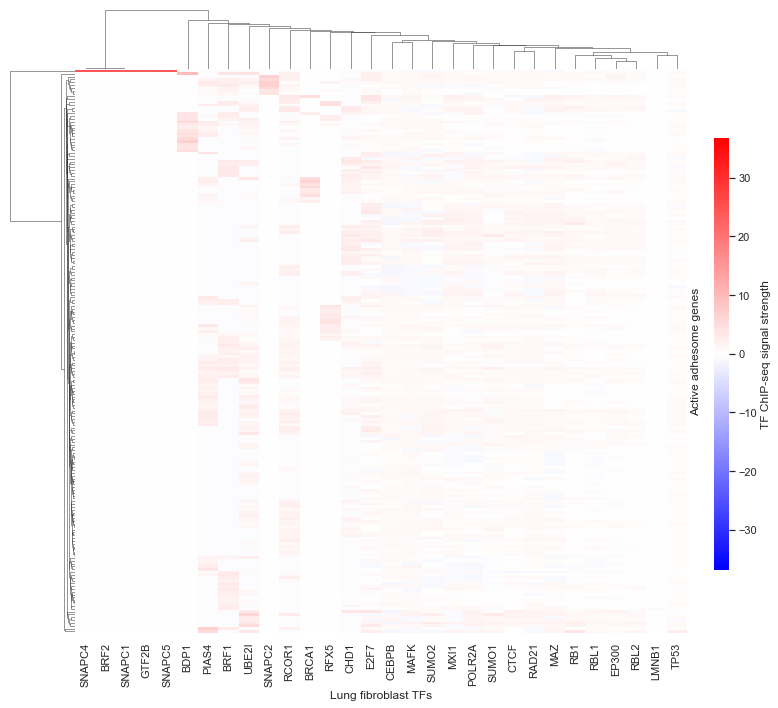

In [77]:
# Display clustered heatmap of cistromic marks for active adhesome genes
maxval = np.abs(mapped_peaks_df).max().max()
mapped_peaks_df.index.name = 'Active adhesome genes'

plt.figure()
sns.clustermap(
    mapped_peaks_df.loc[active_adhesome_genes_sub, :],
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=0.1,
    yticklabels=False,
    cmap='bwr',
    vmax=maxval,
    vmin=-maxval,
    cbar_pos=(1, 0.2, 0.02, 0.6)
)
plt.ylabel('TF ChIP-seq signal strength')
plt.show()

mapped_peaks_df.index.name = 'Active genes'

In [55]:
# Select random active genes (same number as adhesome genes)
np.random.seed(10)
active_random_genes = np.random.choice(
    list(set(mapped_peaks_df.index)-set(inactive_genes)-set(active_adhesome_genes)),
    size=len(active_adhesome_genes_sub),
    replace=False
)

<Figure size 432x288 with 0 Axes>

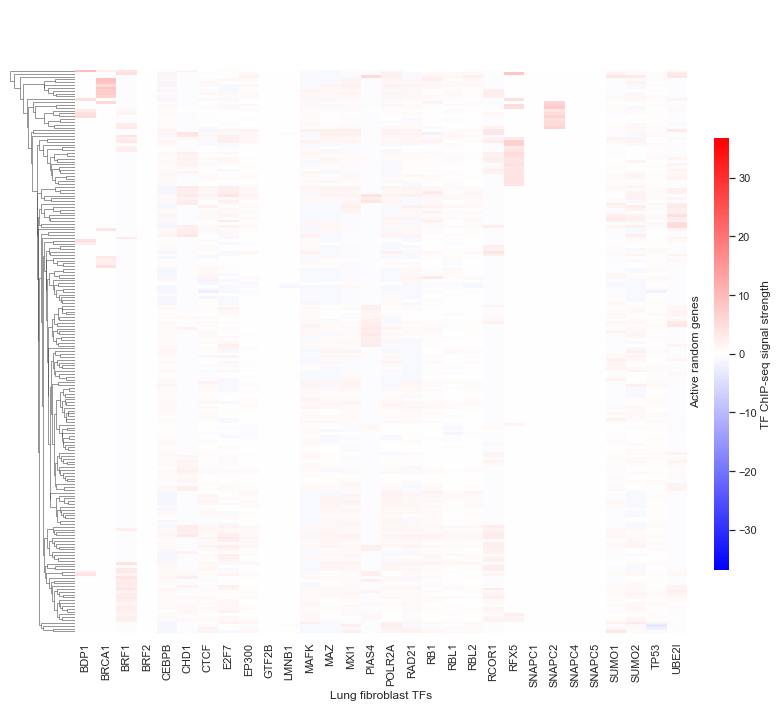

In [56]:
# Display clustered heatmap of cistromic marks for active adhesome genes
maxval = np.abs(mapped_peaks_df).max().max()
mapped_peaks_df.index.name = 'Active random genes'

plt.figure()
sns.clustermap(
    mapped_peaks_df.loc[active_random_genes, :],
    row_cluster=True,
    col_cluster=False,
    dendrogram_ratio=0.1,
    yticklabels=False,
    cmap='bwr',
    vmax=maxval,
    vmin=-maxval,
    cbar_pos=(1, 0.2, 0.02, 0.6)
)
plt.ylabel('TF ChIP-seq signal strength')
plt.show()

mapped_peaks_df.index.name = 'Active genes'

In [163]:
# Redefine active random genes to actually be all active genes except active adhesome genes
active_random_genes = np.array(list(set(mapped_peaks_df.index)-set(inactive_genes)-set(active_adhesome_genes)))
peaks_for_random_dict = {
    col: mapped_peaks_df.loc[active_random_genes, col].values for col in mapped_peaks_df.columns
}

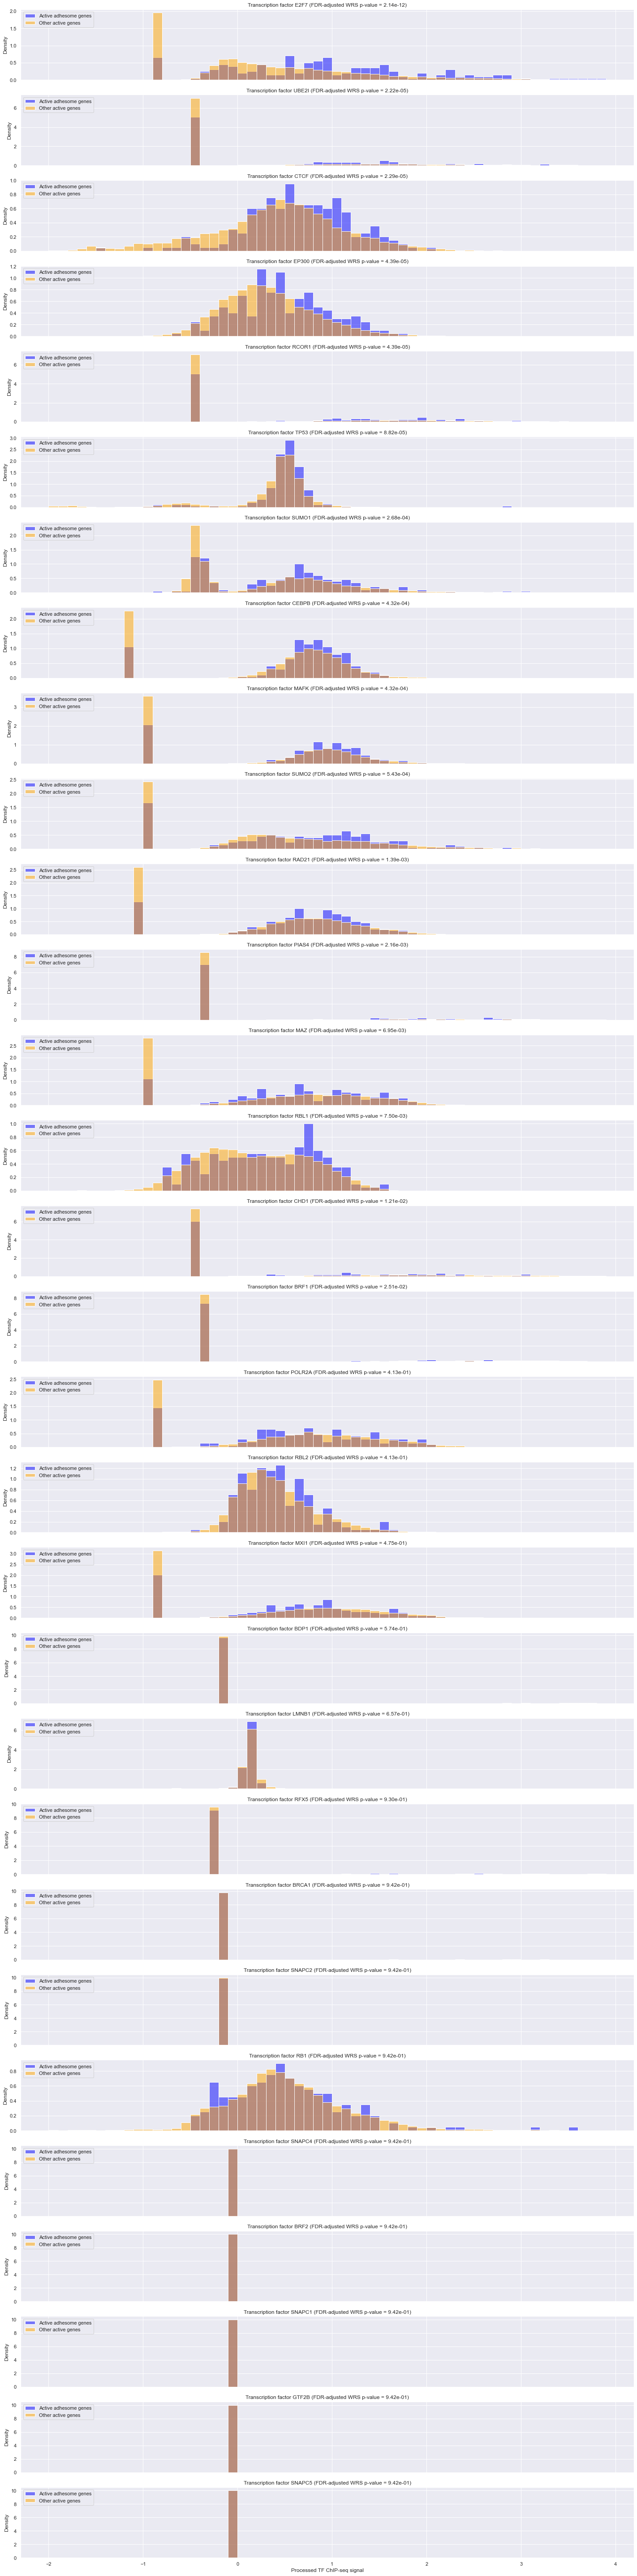

In [164]:
# Look at distribution of signal for each TF
fig, axes = plt.subplots(
    nrows=len(peaks_for_adhesome_dict.keys()), 
    ncols=1, 
    figsize=(20, 80), 
    sharex=True, 
    sharey=False
)

maxval = max([
    max(np.abs(list(itertools.chain.from_iterable(list(peaks_for_adhesome_dict.values()))))), 
    max(np.abs(list(itertools.chain.from_iterable(list(peaks_for_random_dict.values())))))
])
maxval = 2.5

# Create list of TFs ordered by their significance (to have plots in increasing order of significance)
ordered_tf_list = []
for tf in peaks_for_adhesome_dict.keys():
    df_adhesome = pd.DataFrame({'peaks': peaks_for_adhesome_dict[tf], 'Genes': 'Active adhesome genes'})
    df_random = pd.DataFrame({'peaks': peaks_for_random_dict[tf], 'Genes': 'Active random genes'})
    df_combined = pd.concat([df_adhesome, df_random], axis=0).reset_index(drop=True)
    
    stat, pval = ss.ranksums(
        x=df_adhesome['peaks'].values,
        y=df_random['peaks'].values,
        alternative='two-sided'
    )
    ordered_tf_list.append((tf, pval))
ordered_tf_list = sorted(ordered_tf_list, key=lambda x: x[1])
ordered_pval_list = [x[1] for x in ordered_tf_list]
ordered_tf_list = [x[0] for x in ordered_tf_list]

# BH FDR correction of TF p-values
ordered_adjusted_pval_list = multipletests(
    ordered_pval_list, 
    alpha=0.05,
    method='fdr_bh',
    is_sorted=True
)[1]

# Plot the histograms on each subplot
for i, tf in enumerate(ordered_tf_list):
    df_adhesome = pd.DataFrame({'peaks': peaks_for_adhesome_dict[tf], 'Genes': 'Active adhesome genes'})
    df_random = pd.DataFrame({'peaks': peaks_for_random_dict[tf], 'Genes': 'Active random genes'})
    df_combined = pd.concat([df_adhesome, df_random], axis=0).reset_index(drop=True)
    pval = ordered_adjusted_pval_list[i]
    
    sns.histplot(
        data=df_adhesome, 
        x='peaks',
        stat='density',
        bins=np.arange(-2, 4, 0.1),
        color='blue',
        alpha=0.5,
        label='Active adhesome genes',
        ax=axes[i]
    )
    sns.histplot(
        data=df_random, 
        x='peaks',
        stat='density',
        bins=np.arange(-2, 4, 0.1),
        color='orange',
        alpha=0.5,
        label='Other active genes',
        ax=axes[i]
    )
    axes[i].legend(loc='upper left')
    axes[i].set_title(
        f"Transcription factor {tf} (FDR-adjusted WRS p-value = {'{:.2e}'.format(pval)})"
    )

# Set common x-axis label
plt.xlabel('Processed TF ChIP-seq signal')

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()

<Figure size 432x288 with 0 Axes>

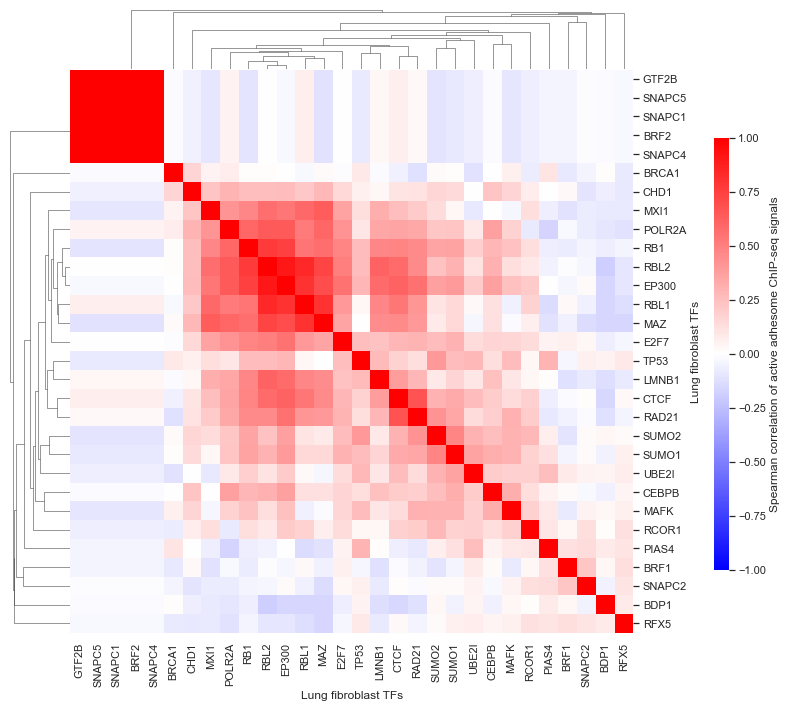

In [118]:
# Correlation between transcription factors
corr_allgenes_df = mapped_peaks_df.loc[active_adhesome_genes_sub, :].corr(method='spearman')
tf_linkage = linkage(
    y=mapped_peaks_df.loc[active_adhesome_genes_sub, :].values.T,
    method='average',
    metric='cosine',
    optimal_ordering=True
)

plt.figure()
sns.clustermap(
    corr_allgenes_df,
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=0.1,
    xticklabels=True,
    yticklabels=True,
    row_linkage=tf_linkage,
    col_linkage=tf_linkage,
    cmap='bwr',
    vmax=1,
    vmin=-1,
    cbar_pos=(1, 0.2, 0.02, 0.6),
    figsize=(10,10)
)
plt.ylabel('Spearman correlation of active adhesome ChIP-seq signals')
plt.show()

<Figure size 432x288 with 0 Axes>

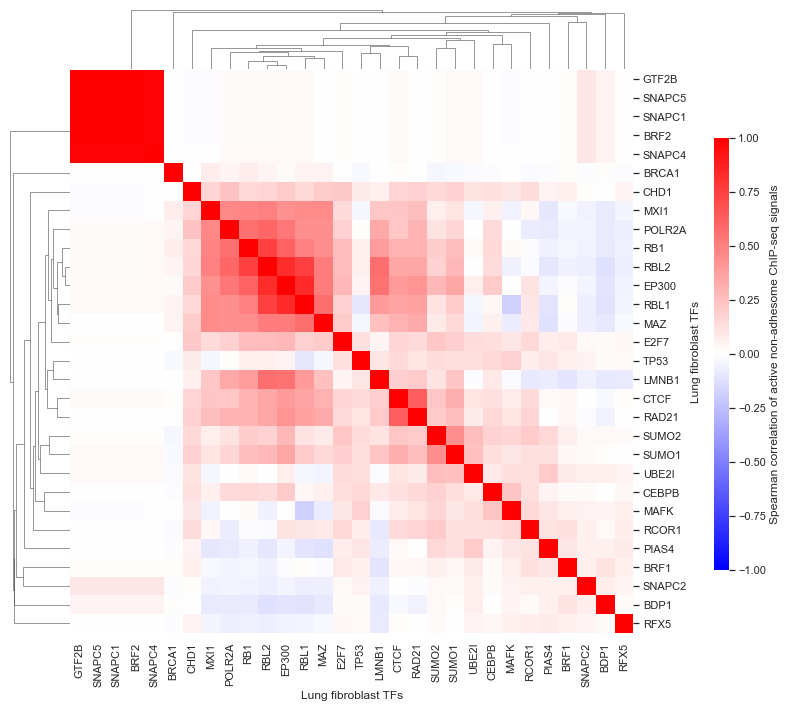

In [119]:
# Correlation between transcription factors
corr_allgenes_df = mapped_peaks_df.loc[active_genes_sub, :].drop(active_adhesome_genes_sub, axis=0)
corr_allgenes_df = corr_allgenes_df.corr(method='spearman')

plt.figure()
sns.clustermap(
    corr_allgenes_df,
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=0.1,
    xticklabels=True,
    yticklabels=True,
    row_linkage=tf_linkage,
    col_linkage=tf_linkage,
    cmap='bwr',
    vmax=1,
    vmin=-1,
    cbar_pos=(1, 0.2, 0.02, 0.6),
    figsize=(10,10)
)
plt.ylabel('Spearman correlation of active non-adhesome ChIP-seq signals')
plt.show()